[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Leo-ChenYZ/Explainable-AI/blob/main/Assignments/Mechanistic_Interpretability/mechanistic_interp.ipynb)

# Mechanistic Interpretability Assignment - Leo Chen

Use this notebook as starter code for your Mechanistic Interpretability assignment. You should build your own tiny model on a tiny problem.

This could be:

* Counting 1s in binary strings (like shown here)

* Reversing short character sequences

* XOR or parity classification

* Or any other toy task you design yourself!


**Methods shown in this notebook:**
* Training a small MLP to solve a regression task (predicting the count of 1s)

* Visualizing hidden layer activations averaged by input type (number of 1s)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

**Additional methods you can try for your problem:**
* Inspecting activations for specific inputs (not just averaged)

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

* Perturbing inputs (e.g., flipping bits) to observe model robustness

* Comparing intermediate representations across training checkpoints

## Define and Train Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Data Generation
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(binary_str)
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)

class CountingMLP_V2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        # The above code snippet was generated using GPT-5 on 11/13/25 at 04:50p.

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        out = self.fc3(h2)
        return out, h2  # Return output and last hidden layer activations

model = CountingMLP_V2(input_dim=seq_length, hidden_dim1=16, hidden_dim2=10)
print(model)

y_train_reg = y_train.float().unsqueeze(1);
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")

CountingMLP_V2(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.0557122565805912
Validation MAE: 0.19
Rounded Accuracy: 0.95


## Sample Activations

In [4]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")

Sample Input: tensor([[1., 0., 1., 0., 1., 1., 0., 0.]])
Hidden Layer Activations: tensor([[0.6704, 2.2854, 3.6094, 1.9477, 0.0000, 0.0000, 0.0000, 1.7978, 0.0000,
         0.4312]])
Output Logits: tensor([[4.0955]])
Rounded Prediction: 4


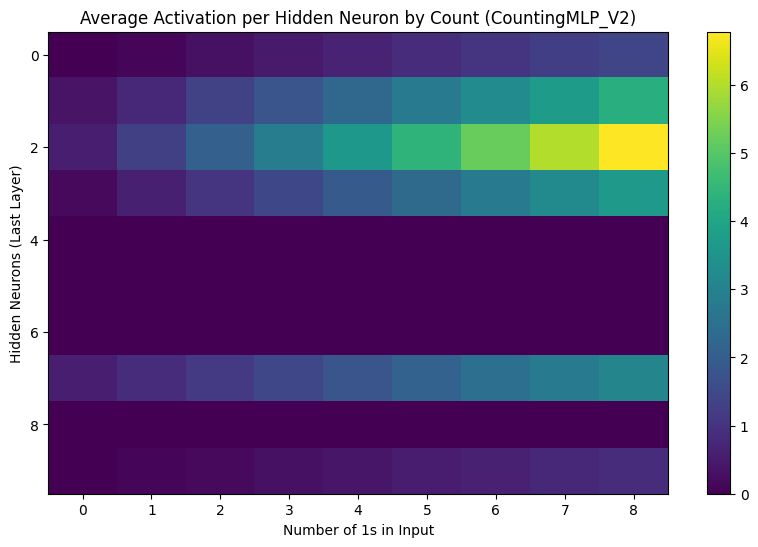

In [5]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, model.fc3.in_features)) # Use model.fc3.in_features for the last hidden layer dimension

model.eval()
with torch.no_grad():
    for c in counts:
        class_inputs = X_val[y_val == c]
        if class_inputs.shape[0] > 0:
            _, h = model(class_inputs)
            avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons (Last Layer)")
plt.title("Average Activation per Hidden Neuron by Count (CountingMLP_V2)")
plt.colorbar()
plt.show()

### Neuron Ablation (single neuron)

In [6]:
import torch.nn.functional as F

# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

neuron_to_zero = 3

with torch.no_grad():
    h1 = F.relu(model.fc1(test_input))
    h2 = F.relu(model.fc2(h1))
    h2[:, neuron_to_zero] = 0
    modified_output = model.fc3(h2)
    modified_pred = modified_output.item()

print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed in last hidden layer): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")

True count: 4
Prediction (normal): 4.08
Prediction (with neuron 3 zeroed in last hidden layer): 3.58
➖ Prediction decreased by 0.50


### Neuron Ablation (sweep of neurons)

🧾 True count: 4, Baseline prediction: 4.08


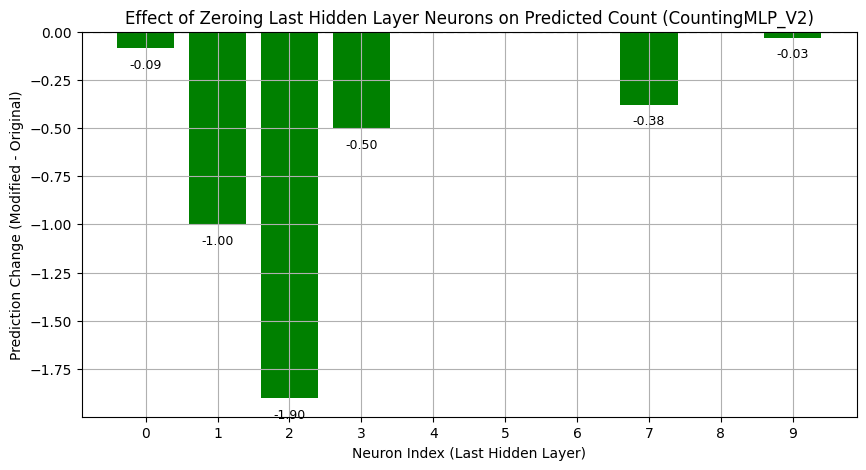


Summary of Neuron Ablation on Last Hidden Layer:
Neuron 0 → Prediction decreased by 0.09
Neuron 1 → Prediction decreased by 1.00
Neuron 2 → Prediction decreased by 1.90
Neuron 3 → Prediction decreased by 0.50
Neuron 7 → Prediction decreased by 0.38
Neuron 9 → Prediction decreased by 0.03


In [7]:
import torch.nn.functional as F

# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction for the last hidden layer
neuron_indices = list(range(model.fc3.in_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h1 = F.relu(model.fc1(test_input))
        h2 = F.relu(model.fc2(h1))
        h2[:, i] = 0
        mod_output = model.fc3(h2)
        mod_pred = mod_output.item()
        signed_deltas.append(mod_pred - baseline_pred)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index (Last Hidden Layer)")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Last Hidden Layer Neurons on Predicted Count (CountingMLP_V2)")
plt.grid(True)

# Annotation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.05 if d > 0 else -0.05), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top', fontsize=9)

plt.show()

print("\nSummary of Neuron Ablation on Last Hidden Layer:")
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} \u2192 Prediction {direction} by {abs(d):.2f}")
        # The above code snippet was generated using GPT-5 on 11/14/25 at 12:25a.

### Explain

**1. Model Performance:**
- The `CountingMLP_V2` model with two hidden layers (16 and 10 neurons) achieved a validation MAE of **0.19** and a rounded accuracy of **0.95**.

**2. Hidden Layer Activations (Averaged by Count):**
- `CountingMLP_V2`'s last hidden layer (10 neurons) shows clear signs of neuron specialization. Several neurons exhibit monotonic trends, increasing their activation as the number of '1's in the input increases. This indicates that these neurons are learning to linearly represent the count feature.
- Some neurons in `CountingMLP_V2` still remain relatively dark or flatlined, suggesting they might be redundant or less active for the given task.

**3. Neuron Ablation (Single Neuron):**
- For `CountingMLP_V2`, zeroing out a specific neuron (neuron 3 for `test_input = [1, 0, 1, 1, 0, 0, 1, 0]` with true count 4) resulted in a prediction decrease of **0.50**. This indicates that the ablated neuron played a significant role in the model's output for that specific input.
- Ablating a neuron led to changes in prediction, highlighting the functional importance of individual neurons.

**4. Neuron Ablation (Sweep of Neurons):**
- The sweep ablation for `CountingMLP_V2` revealed that several neurons in the last hidden layer significantly impact the prediction when zeroed out. Neurons 1, 2, and 3 showed substantial decreases in prediction (Neuron 1: -1.00, Neuron 2: -1.90, Neuron 3: -0.50).
- Some neurons in `CountingMLP_V2` had minimal to no impact when ablated (neurons 4, 5, 6, 8), suggesting potential redundancy or less critical roles.

### Reflect

**What did you learn about how your model works?**
I learned that even a relatively simple MLP can effectively learn to count '1's in binary strings. The interpretability analysis showed that the neurons in the last hidden layer do specialize, with some neurons showing clear monotonic activation patterns directly correlated with the count. This indicates that the model is forming an internal representation of the 'count' feature, rather than just memorizing inputs.

**What was confusing, surprising, or challenging to interpret?**
It was somewhat confusing that even with a clear counting task, some neurons in the hidden layers remained mostly inactive or had minimal impact when ablated. This suggests potential redundancy or that the model found simpler ways to achieve the task without fully utilizing all available neurons. It was also challenging to precisely pinpoint *why* certain neurons became highly specialized while others did not, especially without a more detailed visualization of their weights and activations across the entire dataset.

**What's one thing you wish you could understand better or explore further?**
I wish I could better understand the precise role of each neuron, but I imagine that would be very hard.